# Behavior transition probabilities

This script calculates the transition probabilities for zebra behaviors (Grevy's and Plains) from the subset of KABR sessions originally included in the initial mini-scene release.

### Download dataset from HuggingFace

Use 'consolidated_metadata.csv' file from [KABR Drone Wildlife Monitoring Dataset](https://huggingface.co/datasets/imageomics/kabr-behavior-telemetry/tree/main/data/consolidated_metadata.csv) for data used in this case study.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data/consolidated_metadata.csv')

In [4]:
zebras = data[data['label'] == 'Zebra']
zebras = zebras[['frame', 'id', 'behaviour', 'video']]
zebras['time'] = pd.to_datetime(zebras['frame'], unit='s') - pd.to_datetime(zebras['frame'], unit='s').min()

In [5]:
zebras['behaviour'].unique()

array(['Walk', 'Head Up', 'Out of Frame', 'Graze', 'Occluded',
       'Out of Focus', 'Auto-Groom', 'Defecating', 'Trotting', 'Running',
       'Sniff', 'Mutual Grooming', 'Urinating', 'Fighting'], dtype=object)

In [7]:
zebras.head(12)

,frame,id,behaviour,video,time
0,0,2.0,Walk,12_01_23-DJI_0994,0 days 00:00:00
1,0,1.0,Walk,12_01_23-DJI_0994,0 days 00:00:00
2,1,2.0,Walk,12_01_23-DJI_0994,0 days 00:00:01
3,1,1.0,Walk,12_01_23-DJI_0994,0 days 00:00:01
4,2,2.0,Walk,12_01_23-DJI_0994,0 days 00:00:02
5,2,1.0,Walk,12_01_23-DJI_0994,0 days 00:00:02
6,3,2.0,Walk,12_01_23-DJI_0994,0 days 00:00:03
7,3,1.0,Walk,12_01_23-DJI_0994,0 days 00:00:03
8,4,2.0,Walk,12_01_23-DJI_0994,0 days 00:00:04
9,4,1.0,Walk,12_01_23-DJI_0994,0 days 00:00:04


In [9]:
# zebras_sorted = zebras_sorted[zebras_sorted['behaviour'] != 'Out of Frame']

zebras = zebras[zebras['behaviour'] != 'Out of Frame']
zebras = zebras[zebras['behaviour']!= 'Occluded']
zebras = zebras[zebras['behaviour'] != 'Out of Focus']

In [10]:
len(zebras)

933190

In [11]:
zebras['time'].max()


Timedelta('0 days 02:25:22')

In [8]:
# combine behavior categories into stand-graze, walk, trot, and run
zebras['behaviour'] = zebras['behaviour'].replace('Graze', 'Graze')
zebras['behaviour'] = zebras['behaviour'].replace('Walk', 'Walk')
zebras['behaviour'] = zebras['behaviour'].replace('Trotting', 'Trot')
zebras['behaviour'] = zebras['behaviour'].replace('Running', 'Run')

# drop all other categories of behavior
zebras = zebras[zebras['behaviour'].isin(['Graze', 'Walk', 'Trot', 'Run'])]

In [15]:
# downsample to 10 sec (30 fps)
zebras = zebras[zebras['time'].dt.seconds % (300) == 0]

In [16]:
# count each occurance of transitions between behaviours
# create dataframe to store the counts of transitions from one behaviour to another
behaviors = zebras['behaviour'].unique()
transition_counts = pd.DataFrame(index=behaviors, columns=behaviors)
transition_counts = transition_counts.fillna(0)

In [17]:
# count the occurance of each transition for each unique zebra (id)
for video in zebras['video'].unique():
    for zebra in zebras[zebras['video'] == video]['id'].unique():
        zebra_data = zebras[(zebras['video'] == video) & (zebras['id'] == zebra)]
        for i in range(1, len(zebra_data)):
            transition_counts.loc[zebra_data.iloc[i-1]['behaviour'], zebra_data.iloc[i]['behaviour']] += 1

In [16]:
transition_counts

,Walk,Graze,Run,Trot
Walk,650,97,16,20
Graze,95,1004,0,2
Run,8,0,26,4
Trot,15,3,4,6


In [17]:
# normalize transitions by the total number of transitions
transition_counts_normalized = transition_counts.div(transition_counts.sum(axis=1), axis=0)
transition_counts_normalized

,Walk,Graze,Run,Trot
Walk,0.830140,0.123883,0.020434,0.025543
Graze,0.086285,0.911898,0.000000,0.001817
Run,0.210526,0.000000,0.684211,0.105263
Trot,0.535714,0.107143,0.142857,0.214286


In [20]:
# convert to percentages and rounds to 2 decimal places
transition_counts_normalized =round(transition_counts_normalized * 100, 2)

In [21]:
transition_counts_normalized
# switch order of walk and stand-graze in the table
transition_counts_normalized = transition_counts_normalized[['Graze', 'Walk', 'Trot', 'Run']]
#transition_counts_normalized = transition_counts_normalized.reindex(['Graze', 'Walk', 'Trot', 'Run'])


In [22]:
# calculate the percentages row-wise for transitions
transition_percentages = transition_counts.div(transition_counts.sum(axis=1), axis=0)
# sort rows and columns by the order of the behaviors
behaviors = transition_percentages.columns
transition_percentages = transition_percentages.reindex(behaviors, axis=0)
transition_percentages = transition_percentages.reindex(behaviors, axis=1)
transition_percentages = round(transition_percentages*100, 2)

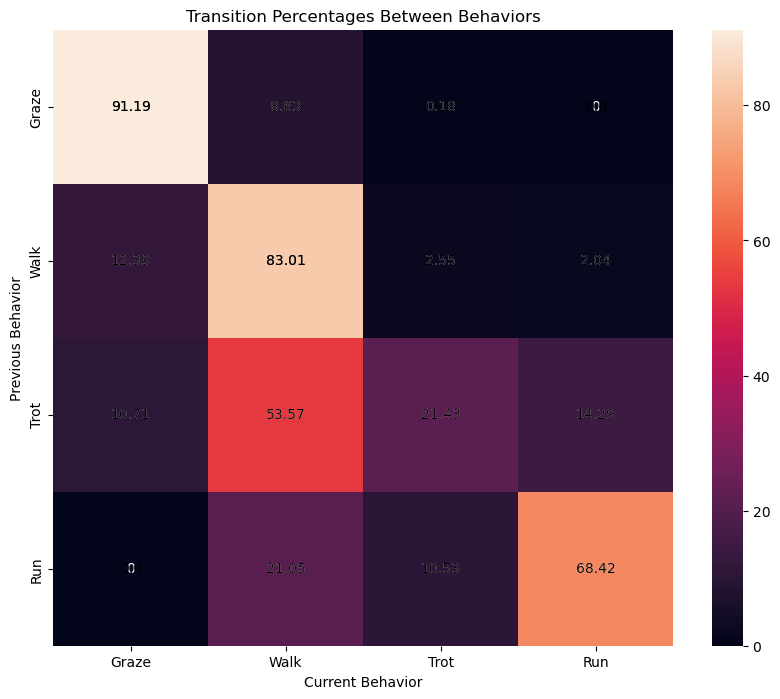

In [24]:
# Reorder rows and columns to switch "Walk" and "Graze"
reordered_behaviors = ['Graze', 'Walk', 'Trot', 'Run']
transition_percentages = transition_percentages.reindex(reordered_behaviors, axis=0)
transition_percentages = transition_percentages.reindex(reordered_behaviors, axis=1)

# Plot the heatmap with the updated order
plt.figure(figsize=(10, 8))
sns.heatmap(transition_percentages, cmap='rocket', annot=True, fmt='g')

# Add numbers on each cell
for i in range(len(reordered_behaviors)):
    for j in range(len(reordered_behaviors)):
        plt.text(j + 0.5, i + 0.5, transition_percentages.iloc[i, j],
                 horizontalalignment='center',
                 verticalalignment='center')

plt.title('Transition Percentages Between Behaviors')
plt.xlabel('Current Behavior')
plt.ylabel('Previous Behavior')
plt.show()

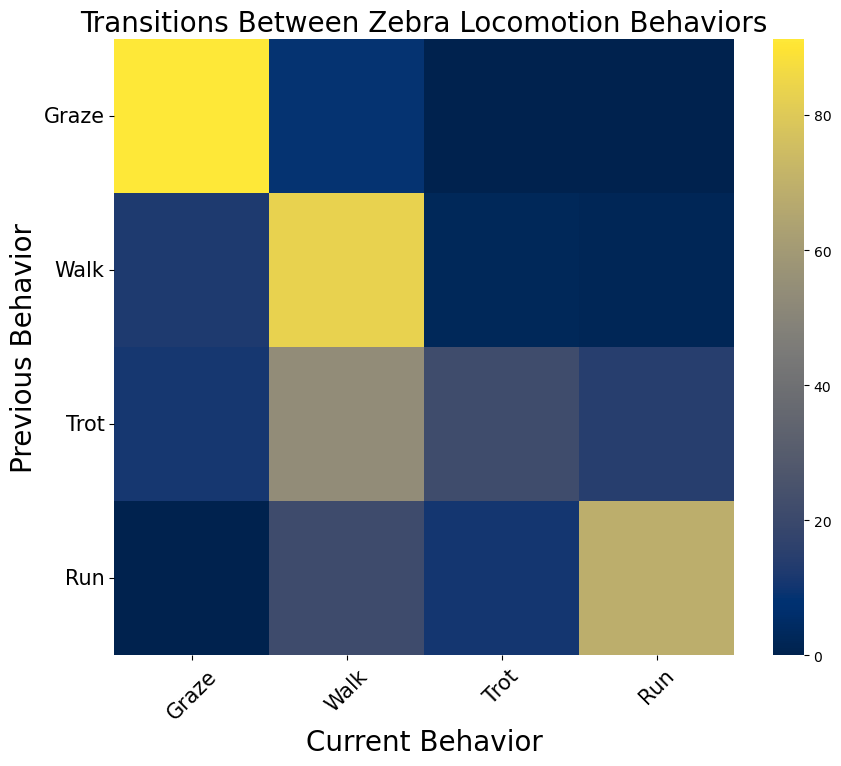

In [27]:
# heatmap of transition percentages
plt.figure(figsize=(10, 8))
sns.heatmap(transition_percentages, cmap='cividis', fmt='g')
plt.title('Transitions Between Locomotion Behavior Categories (1 second intervals)')
plt.xticks(rotation=45, fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.title('Transitions Between Zebra Locomotion Behaviors', fontsize=20)
plt.xlabel('Current Behavior', fontsize=20)
plt.ylabel('Previous Behavior', fontsize=20)
plt.show()